# WAMECU Bias Simulation Prototype

This notebook provides a minimal simulation environment for exploring the WAMECU framework — an AI-assisted approach to quantifying bias in systems that are often treated as random. The notebook generates synthetic draws under controlled bias coefficients, illustrates how the WAMECU adjustment modifies baseline probabilities, and offers simple diagnostics for detecting and estimating bias.

## 1. Imports and Utilities

The helper functions below implement the core WAMECU relationship. The `wamecu_probabilities` function converts a vector of bias coefficients into a probability distribution. Bias coefficients are expected to average to zero; however, the helper function defensively normalizes the distribution to account for rounding or exploratory inputs. The `simulate_draws` utility produces synthetic outcome data so the rest of the notebook can focus on analysis.

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use("seaborn-v0_8")

project_root = Path().resolve()
for candidate in {project_root / "src", project_root.parent / "src"}:
    if candidate.exists() and str(candidate) not in sys.path:
        sys.path.append(str(candidate))

from wamecu import simulate_draws, wamecu_probabilities


## 2. Define a Baseline Scenario

Start with a six-outcome system (e.g., a standard die). The bias coefficients below emphasize outcome 0 (analogous to side **1** on a die) and depress outcome 5. The remaining values are kept small to emulate subtle mechanical or environmental drift.

In [2]:
n_outcomes = 6
beta = np.array([0.08, 0.02, -0.01, -0.02, 0.0, -0.07])
probabilities = wamecu_probabilities(n_outcomes, beta)
probabilities

array([0.18      , 0.17      , 0.165     , 0.16333333, 0.16666667,
       0.155     ])

The resulting distribution is close to the baseline 1/6 for each outcome but exhibits a measurable skew. Outcome 0 is favored, while outcome 5 is suppressed. The distribution is automatically renormalized so that the probabilities sum to 1.

## 3. Simulate Synthetic Draws

Run a set of synthetic trials to observe how the bias manifests in data. A reproducible random seed is used for deterministic runs, making the notebook convenient for demos and unit tests.

In [3]:
n_trials = 20_000
outcomes = simulate_draws(probabilities, n_trials, seed=42)
counts = pd.Series(outcomes).value_counts().sort_index()
counts

0    3616
1    3439
2    3214
3    3307
4    3330
5    3094
Name: count, dtype: int64

## 4. Compare Observed and Expected Frequencies

Visualize the empirical counts against the WAMECU-derived expectations. The chart highlights deviations that an analyst would investigate through anomaly detection or machine learning models within the broader framework.

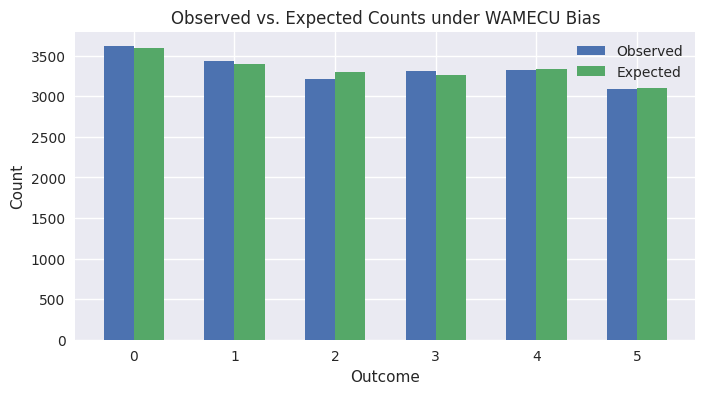

In [4]:
expected_counts = probabilities * n_trials
fig, ax = plt.subplots(figsize=(8, 4))
index = np.arange(n_outcomes)
ax.bar(index - 0.15, counts.values, width=0.3, label="Observed", color="#4C72B0")
ax.bar(index + 0.15, expected_counts, width=0.3, label="Expected", color="#55A868")
ax.set_xlabel("Outcome")
ax.set_ylabel("Count")
ax.set_title("Observed vs. Expected Counts under WAMECU Bias")
ax.set_xticks(index)
ax.legend()
plt.show()

## 5. Estimate Bias Coefficients from Data

Given observed counts, we can produce a quick estimate of the implied bias coefficients. The estimator compares empirical frequencies against the baseline uniform probabilities. In practice, this step would be augmented with confidence intervals, regularization, and domain-specific constraints.

In [5]:
baseline_prob = np.full(n_outcomes, 1.0 / n_outcomes)
empirical_prob = counts.values / n_trials
# Avoid division by zero by masking low-frequency cases.
mask = baseline_prob > 0
estimated_beta = np.zeros_like(empirical_prob)
estimated_beta[mask] = (empirical_prob[mask] / baseline_prob[mask]) - 1
estimated_beta

array([ 0.0848,  0.0317, -0.0358, -0.0079, -0.001 , -0.0718])

These estimated coefficients are noisy due to finite sampling but follow the same pattern as the ground truth. Analysts could feed these estimates into anomaly detection routines, simulation calibrations, or machine learning models — all pillars of the WAMECU workflow.

## 6. Next Steps

* Add physics-driven or data-driven priors that constrain permissible bias coefficients.
* Integrate anomaly detection methods (e.g., Bayesian change-point detection) for streaming data.
* Train adaptive machine learning models on enriched metadata to predict real-time β dynamics.
* Wrap the notebook in a lightweight dashboard for stakeholder reporting.